In [1]:
# Maddie Schwarz, Abdel Hafiz, Mindy Zuckerman, Aswayuja Koduri 
#5/6/2022  SES 598 Autonomous Exploration Systems
from osgeo import gdal, gdal_array
from osgeo import osr
from osgeo import ogr

import subprocess
import os

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve    # Gaussian Filter
from sklearn import cluster             # K-means Clustering

In [2]:
## Functions: ##

# Function that loads raster DEM with GDAL, plots the DEM, then computes 
# a DEM derivative raster (ex: slope map)
def load_dem(in_ras, out_ras_name, deriv_type):
    # params: 
    #        in_ras: path to DEM raster file (single band GTIFF)
    #        out_ras_name: 
    #        process_dem: True or False
    #        deriv_type: "slope", "hillshade", "roughness"
    
    OG_dem = in_ras
    
    #Load GeoTiff Driver
    driver = gdal.GetDriverByName("GTiff")
    OG_dem = gdal.Open(in_ras,1)
    print("opened")
    
    new_ras = "copy_ras.TIF"
    
    dem = driver.CreateCopy(new_ras, OG_dem, strict=0)
    
    #close file to save changes
    OG_dem = None 
    
    dem = gdal.Open(new_ras,1) 

    #Set NoDATA Value to np.nan so it is igrored in plot
    def noData_arr(in_data):
        ndv = in_data.GetRasterBand(1).GetNoDataValue()
        print("NoData Value: ", ndv)
        in_arr = in_data.ReadAsArray().astype(np.float)
        
        if np.any(in_arr <= ndv):
            in_arr[in_arr <= ndv] = np.nan
        return in_arr
    
    # Plot DEM
    dem_arr = noData_arr(dem) 
    print("DEM plot:")
    plt.figure()
    plt.imshow(dem_arr)
    plt.colorbar()
    plt.show()
   
    deriv = gdal.DEMProcessing(out_ras_name, dem, deriv_type, computeEdges=True)
    
    #Set NoDATA Value to np.nan (ignore in plot)
    deriv_arr = noData_arr(deriv)
       
    # Plot Deriv raster
    print(deriv_type, " plot")
    plt.figure(figsize=(10,10))
    plt.imshow(deriv_arr)
    plt.colorbar()
    plt.show()
    
    dem = None

#-------------------------------------------------------
# Function that applies an n-standard deviation stretch to a raster dataset
def std_stretch_data(data, n=2):
    
    # Get the mean and n standard deviations.
    mean, d = data.mean(), data.std() * n

    # Calculate new min and max as integers. Make sure the min isn't
    # smaller than the real min value, and the max isn't larger than
    # the real max value.
    new_min = math.floor(max(mean - d, data.min()))
    new_max = math.ceil(min(mean + d, data.max()))

    # Convert any values smaller than new_min to new_min, and any
    # values larger than new_max to new_max.
    data = np.clip(data, new_min, new_max)

    # Scale the data.
    data = (data - data.min()) / (new_max - new_min)
    return data

#-------------------------------------------------------
# Function that applies gaussian blur to a raster    
# https://gis.stackexchange.com/questions/9431/what-raster-smoothing-generalization-tools-are-available

def gaussian_blur(in_array, size):
    # expand in_array to fit edge of kernel
    padded_array = np.pad(in_array, size, 'symmetric')
    # build kernel
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    g = np.exp(-(x**2 / float(size) + y**2 / float(size)))
    g = (g / g.sum()).astype(in_array.dtype)
    # do the Gaussian blur
    return fftconvolve(padded_array, g, mode='valid')


#-------------------------------------------------------
# Function that converts array to a raster (tiff file)
# https://gist.github.com/jkatagi/a1207eee32463efd06fb57676dcf86c8

def array2raster(newRasterfn, dataset, array, dtype):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform() 

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    # setteing srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    

opened
NoData Value:  -3.4028230607370965e+38
DEM plot:


C:\Users\abdel\AppData\Local\Temp\ipykernel_30468\378413284.py:32: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  in_arr = in_data.ReadAsArray().astype(np.float)


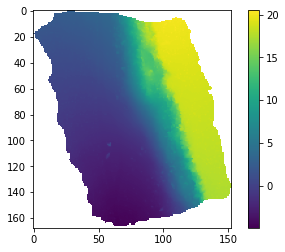

NoData Value:  -9999.0
slope  plot


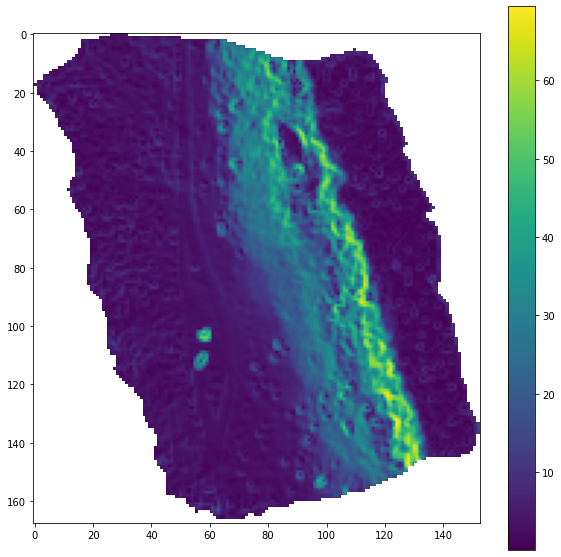

In [3]:
## Generate a slope map from input DEM ##
    ## params: in_ras, out_ras_name, process_dem, deriv_type    
load_dem(r"Bishop/DEM_1m.tif", r"Bishop/slope_1m.TIF", "slope")

C:\Users\abdel\AppData\Local\Temp\ipykernel_30468\1584838620.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sl_arr = slope.GetRasterBand(1).ReadAsArray().astype(np.float)


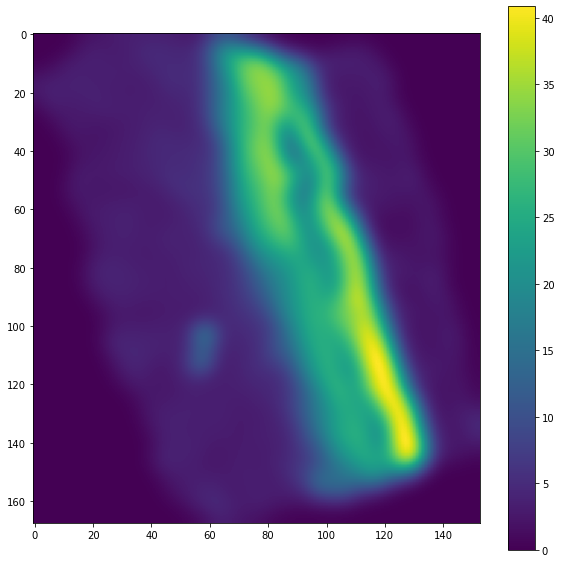

In [4]:
## Apply Gaussian Blur to Slope Map ##

driver = gdal.GetDriverByName("GTiff")
slope = gdal.Open("Bishop/slope_1m.TIF",1)
sl_arr = slope.GetRasterBand(1).ReadAsArray().astype(np.float)

# set NoData Values in array to 0-->nan with gauss gives all nan array
# https://www.tutorialspoint.com/gaussian-filtering-an-image-with-nan-in-python-matplotlib
ndv = slope.GetRasterBand(1).GetNoDataValue()
if np.any(sl_arr <= ndv):
        sl_arr[sl_arr <= ndv] = 0


# Apply Blur filter to slope array
blur = gaussian_blur(sl_arr, 30)

# Plot Deriv raster
plt.figure(figsize=(10,10))
plt.imshow(blur)
plt.colorbar()
plt.show()

In [5]:
blur_name = "bish1m_GaussBlur30.tif"

In [6]:
# generate a raster of Blurred Slope map
array2raster(blur_name, slope, blur, "Float32")

In [7]:
## Use Kmeans to perform cluster analysis on Blurred raster ##

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image, get data from band 1, determine raster shape
img_ds = gdal.Open(blur_name, gdal.GA_ReadOnly)
band = img_ds.GetRasterBand(1)
img = band.ReadAsArray()
print (img.shape)

# flatten data for input into classifier
X = img.reshape((-1,1))
print (X.shape)

#run the classifier
k_means = cluster.KMeans(n_clusters=2)

# Fitting the model to testing set
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)

print(len(X_cluster))

(168, 153)
(25704, 1)
168


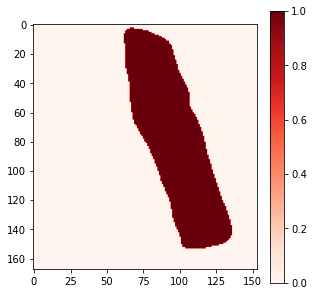

In [8]:
# plot cluster result
plt.figure(figsize=(5,5))
plt.imshow(X_cluster, cmap="Reds")
plt.colorbar()
plt.show()

In [9]:
km_ras_name = "bish1m_KM2_g30_c2.tif"

In [10]:
# generate a raster Kmeans output
array2raster(km_ras_name, slope, X_cluster, "Float32")

In [11]:
# Convert the scarp raster pixels into a polygon
# https://www.e-education.psu.edu/geog489/node/2215

k_ras = gdal.Open(km_ras_name)
k_band = k_ras.GetRasterBand(1)

drv = ogr.GetDriverByName('ESRI Shapefile')  
                            # e.g.: GeoJSON, ESRI Shapefile
    
outfile = drv.CreateDataSource(r'b1m_g30_KM2_poly.shp') 
outlayer = outfile.CreateLayer('polygonized raster', srs = None )
newField = ogr.FieldDefn('DN', ogr.OFTReal)
outlayer.CreateField(newField)

newField2 = ogr.FieldDefn('Area', ogr.OFTReal)
outlayer.CreateField(newField2)

gdal.Polygonize(k_band, None, outlayer, 0, [])

outfile = None

In [12]:
# Calculate Area of polygons and write to attribute table
driver = ogr.GetDriverByName("ESRI Shapefile")
dataSource = driver.Open(r'b1m_g30_KM2_poly.shp', 1)
layer = dataSource.GetLayer()

print("Calculated Area of each polygon:")

for feature in layer:
    geom = feature.GetGeometryRef()
    area = geom.GetArea() 
    print(area)
    feature.SetField("Area", area)
    layer.SetFeature(feature)
datasource = None    

Calculated Area of each polygon:
5517.999999999998
20186.0
